# Forecasting Covid-19 Total Cases and Active Cases using the Facebook Prohphet Library

## Data collection and preparation

In [141]:
import pandas as pd
import matplotlib. pyplot as plt
import numpy as np
from datetime import datetime
%config InlineBackend.figure_format = 'retina'

In [142]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
cdf = pd.read_csv(url) # confirmed

In [143]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
ddf = pd.read_csv(url) # death

In [144]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
rdf = pd.read_csv(url) # recovered

In [145]:
# function to extract data from git hub repo
def extractor(df,y):
    output = df.loc[df['Country/Region'] == y]
    return pd.DataFrame(output)

In [146]:
# function to prepare data for further processing
def plotprep(df):
    numbers = df.iloc[:,4:-1]
    numbers2 = numbers.transpose()
    return numbers2

In [147]:
# importing and preparing world data
cdf1 = cdf.drop(['Province/State','Country/Region','Lat', 'Long'], axis = 1)
ddf1 = ddf.drop(['Province/State','Country/Region','Lat', 'Long'], axis = 1)
rdf1 = rdf.drop(['Province/State','Country/Region','Lat', 'Long'], axis = 1)

cdf1 = cdf.agg(['sum'])
ddf1 = ddf.agg(['sum'])
rdf1 = rdf.agg(['sum'])

cdf1 = cdf1.rename(index={'sum': 'cases'})
ddf1 = ddf1.rename(index={'sum': 'deaths'})
rdf1 = rdf1.rename(index={'sum': 'recoveries'})

world = pd.concat([cdf1, ddf1,rdf1])
world = plotprep(world)

In [148]:
active = world['cases'] - world['deaths'] - world['recoveries']

In [149]:
world['active cases'] = active

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


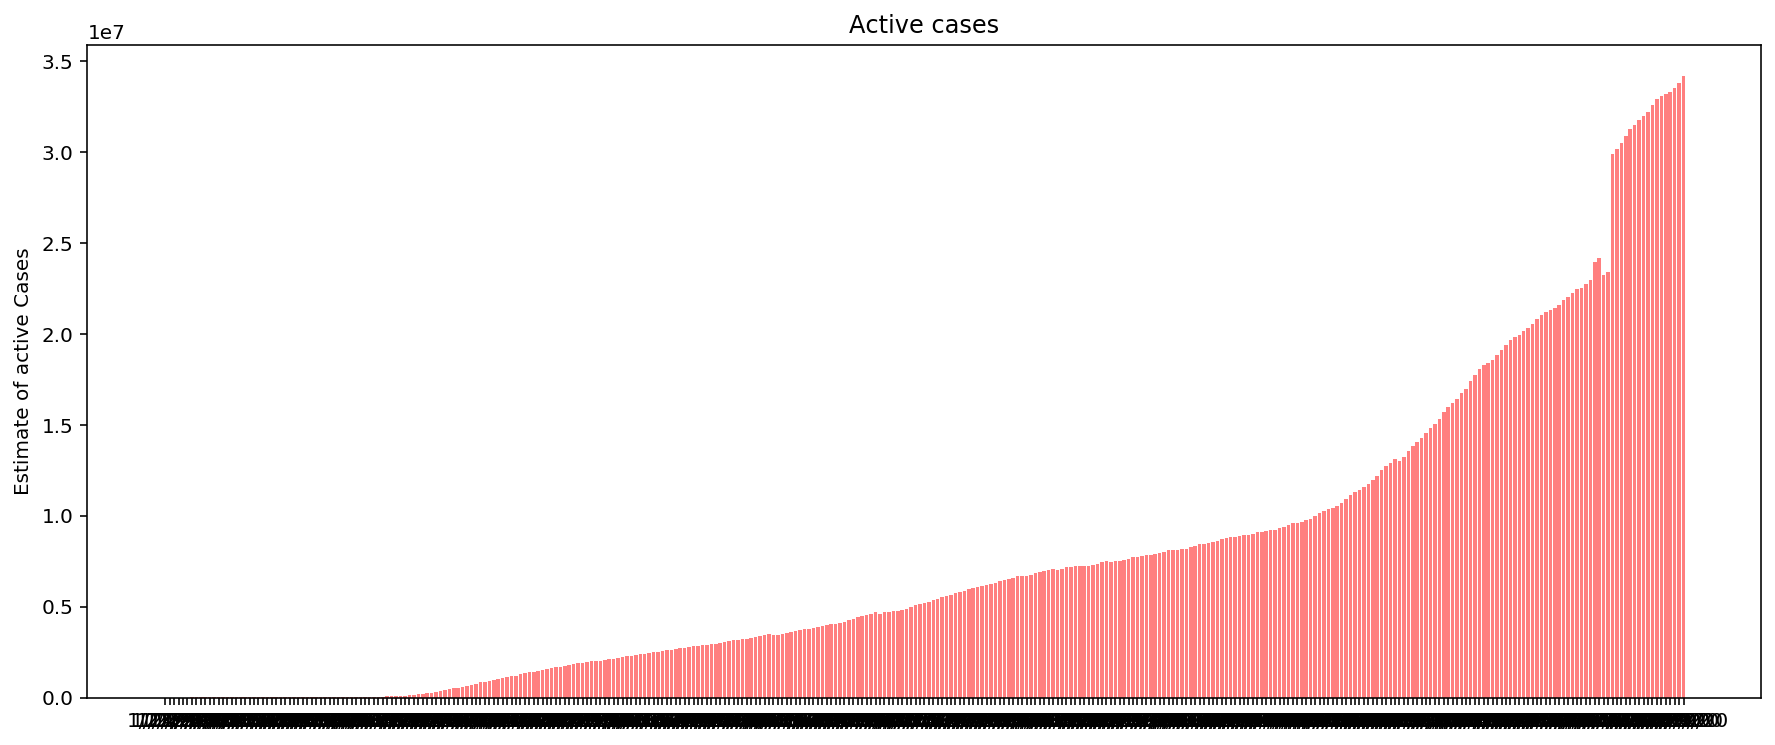

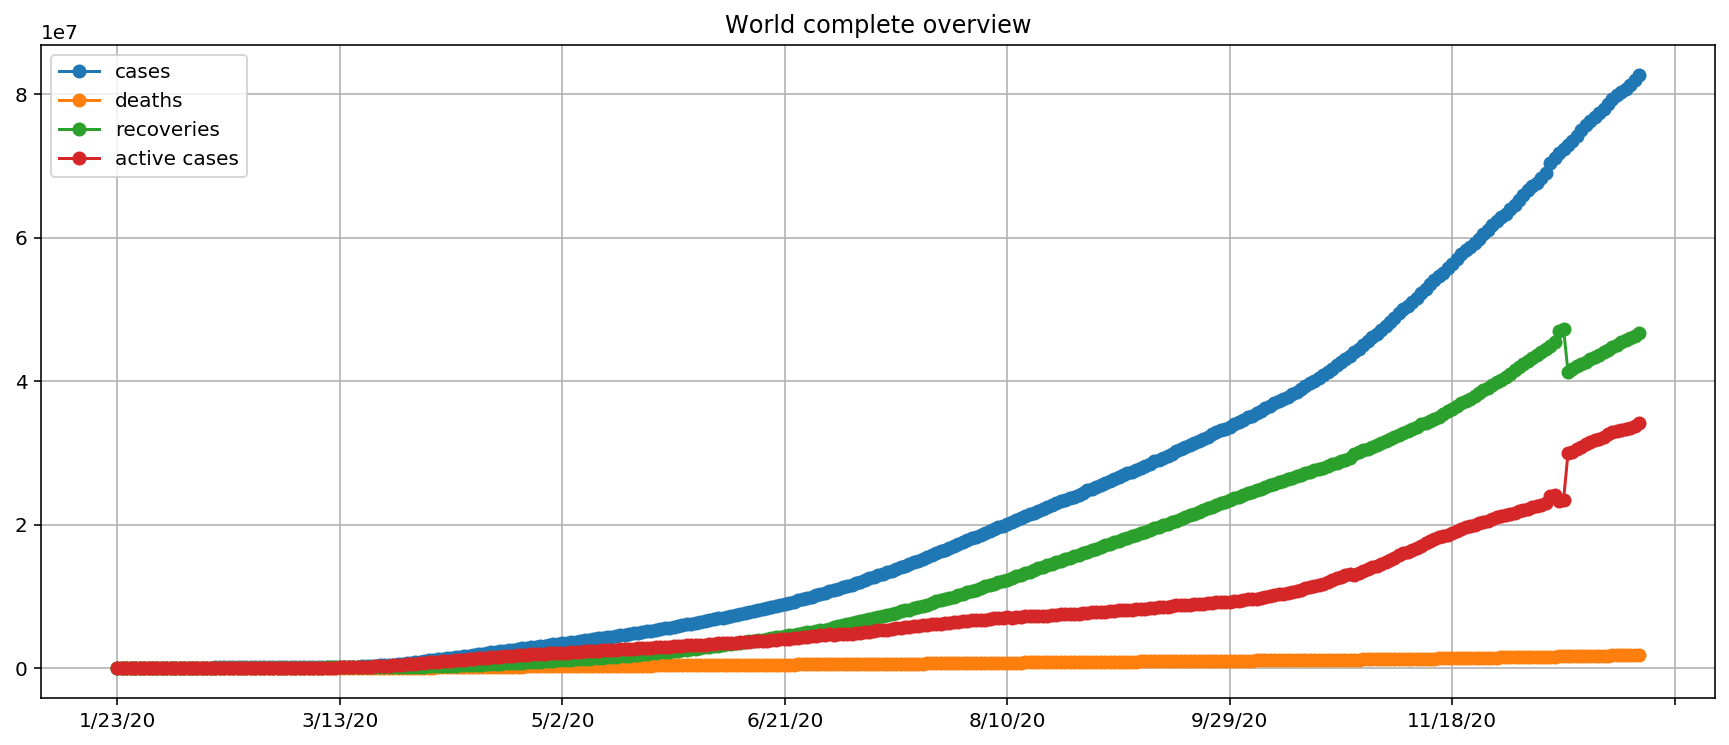

In [150]:
plt.figure(figsize=(15, 6))
plt.bar(world.index, world['active cases'], align='center', alpha=0.5, color = 'red')
plt.ylabel('Estimate of active Cases')
plt.title('Active cases')


ax = world.plot(grid=True, figsize=(15, 6), marker='o', title='World complete overview')
plt.show()

In [151]:
world.head()

,cases,deaths,recoveries,active cases
1/23/20,654,18,30,606
1/24/20,941,26,36,879
1/25/20,1434,42,39,1353
1/26/20,2118,56,52,2010
1/27/20,2927,82,61,2784


In [152]:
world.reset_index(level=0, inplace=True)

In [153]:
world_active_cases = world.copy()

In [154]:
world_cases = world.copy()

In [155]:
world_cases.rename(columns={'index': 'ds', 'cases': 'y'}, inplace=True)

In [156]:
world_active_cases.rename(columns={'index': 'ds', 'active cases': 'y'}, inplace=True)

In [157]:
world_cases.head()

,ds,y,deaths,recoveries,active cases
0,1/23/20,654,18,30,606
1,1/24/20,941,26,36,879
2,1/25/20,1434,42,39,1353
3,1/26/20,2118,56,52,2010
4,1/27/20,2927,82,61,2784


In [158]:
world_active_cases.head()

,ds,cases,deaths,recoveries,y
0,1/23/20,654,18,30,606
1,1/24/20,941,26,36,879
2,1/25/20,1434,42,39,1353
3,1/26/20,2118,56,52,2010
4,1/27/20,2927,82,61,2784


In [159]:
world_cases.drop(['deaths', 'recoveries', 'active cases'], axis=1)

,ds,y
0,1/23/20,654
1,1/24/20,941
2,1/25/20,1434
3,1/26/20,2118
4,1/27/20,2927
...,...,...
338,12/26/20,80364202
339,12/27/20,80797122
340,12/28/20,81285853
341,12/29/20,81951541


In [160]:
world_active_cases.drop(['deaths', 'recoveries', 'cases'], axis=1)

,ds,y
0,1/23/20,606
1,1/24/20,879
2,1/25/20,1353
3,1/26/20,2010
4,1/27/20,2784
...,...,...
338,12/26/20,33196189
339,12/27/20,33334093
340,12/28/20,33517266
341,12/29/20,33812691


## Applying the Prophet Library

In [161]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [162]:
prophet_cases = Prophet(changepoint_prior_scale=0.15, daily_seasonality=False)

In [163]:
prophet_active_cases = Prophet(changepoint_prior_scale=0.15, daily_seasonality=False)

In [164]:
prophet_cases.fit(world_cases)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [165]:
prophet_active_cases.fit(world_active_cases)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [166]:
build_forecast_cases = prophet_cases.make_future_dataframe(periods=10, freq='D')

In [167]:
build_forecast_active_cases = prophet_active_cases.make_future_dataframe(periods=10, freq='D')

In [168]:
forecast_cases = prophet_cases.predict(build_forecast_cases)

In [169]:
forecast_active_cases = prophet_active_cases.predict(build_forecast_active_cases)

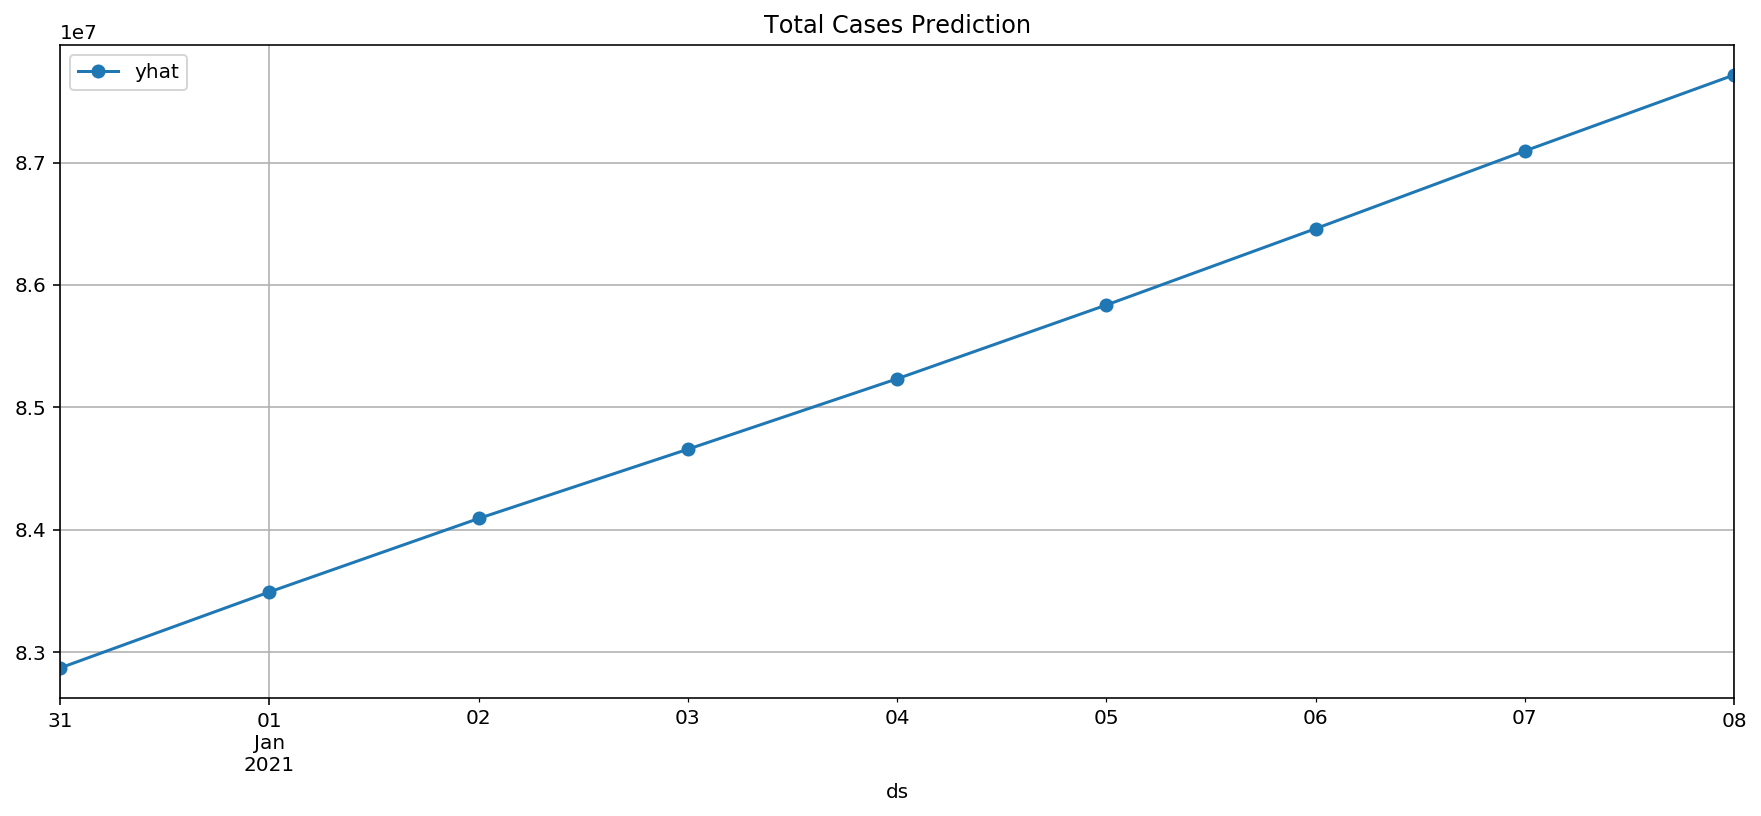

In [170]:
data_cases = forecast_cases[['ds','yhat']].iloc[-10:-1]
data_cases.set_index('ds', inplace=True, drop=True)

ax = data_cases.plot(grid=True, figsize=(15, 6), marker='o', title='Total Cases Prediction')
plt.show()

In [171]:
data_cases

,yhat
ds,
2020-12-31,82868967.216
2021-01-01,83490104.020
2021-01-02,84090518.862
2021-01-03,84656715.048
2021-01-04,85232294.542
2021-01-05,85835595.248
2021-01-06,86459551.081
2021-01-07,87094628.518
2021-01-08,87715765.322


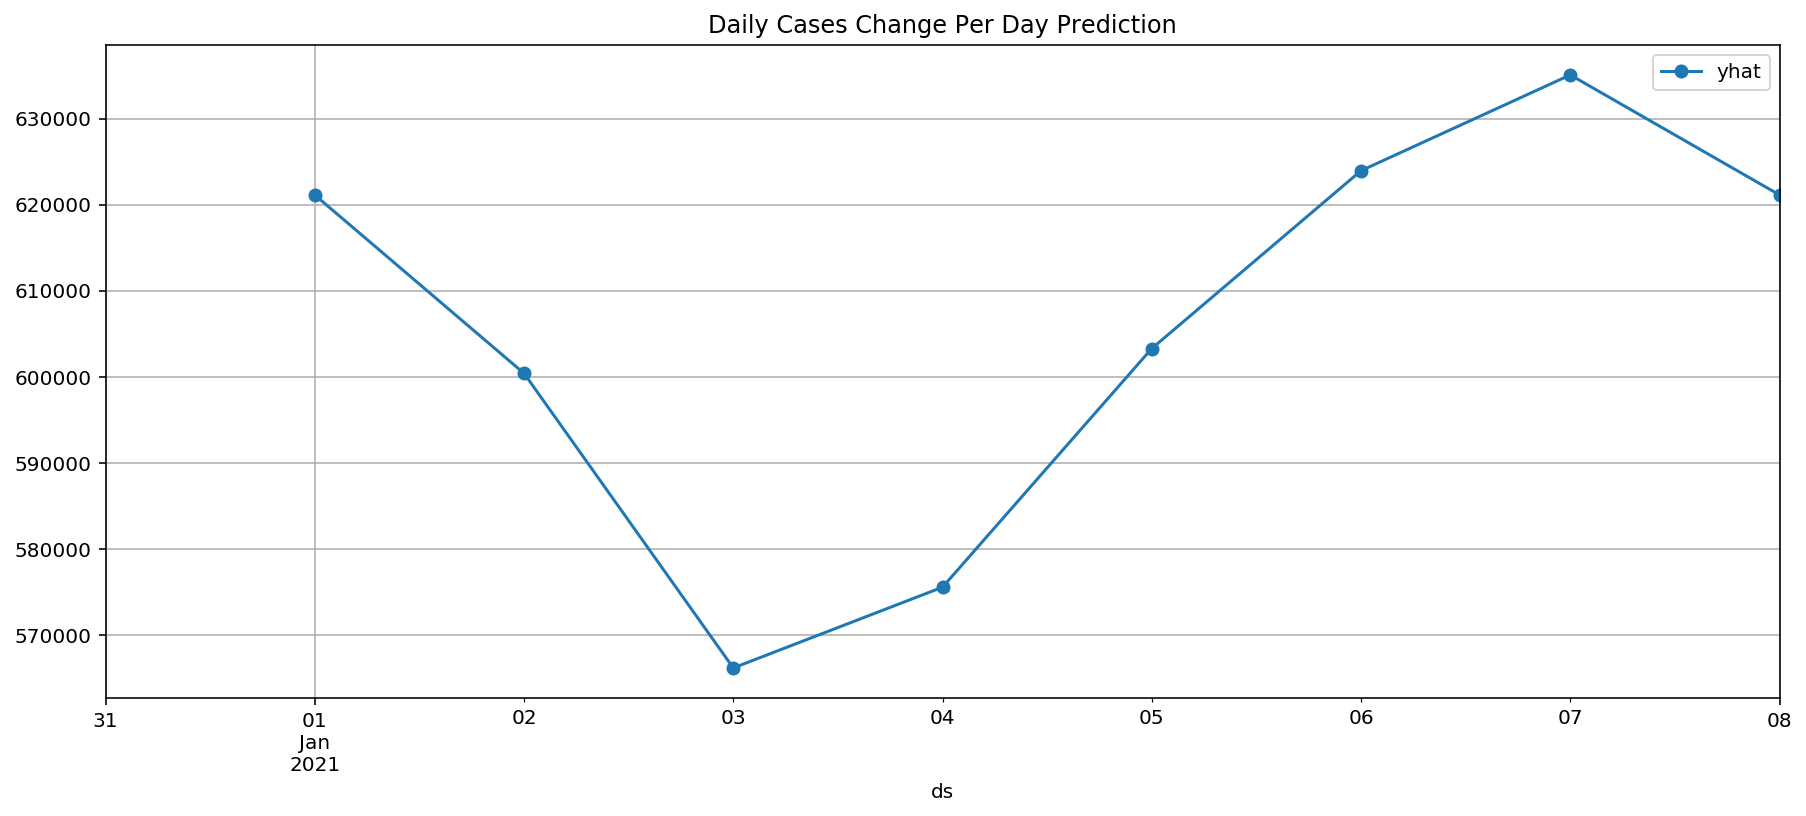

In [172]:
cases_change = data_cases.diff()

ax = cases_change.plot(grid=True, figsize=(15, 6), marker='o', title='Daily Cases Change Per Day Prediction')
plt.show()

In [173]:
cases_change

,yhat
ds,
2020-12-31,nan
2021-01-01,621136.804
2021-01-02,600414.842
2021-01-03,566196.187
2021-01-04,575579.493
2021-01-05,603300.706
2021-01-06,623955.833
2021-01-07,635077.437
2021-01-08,621136.804


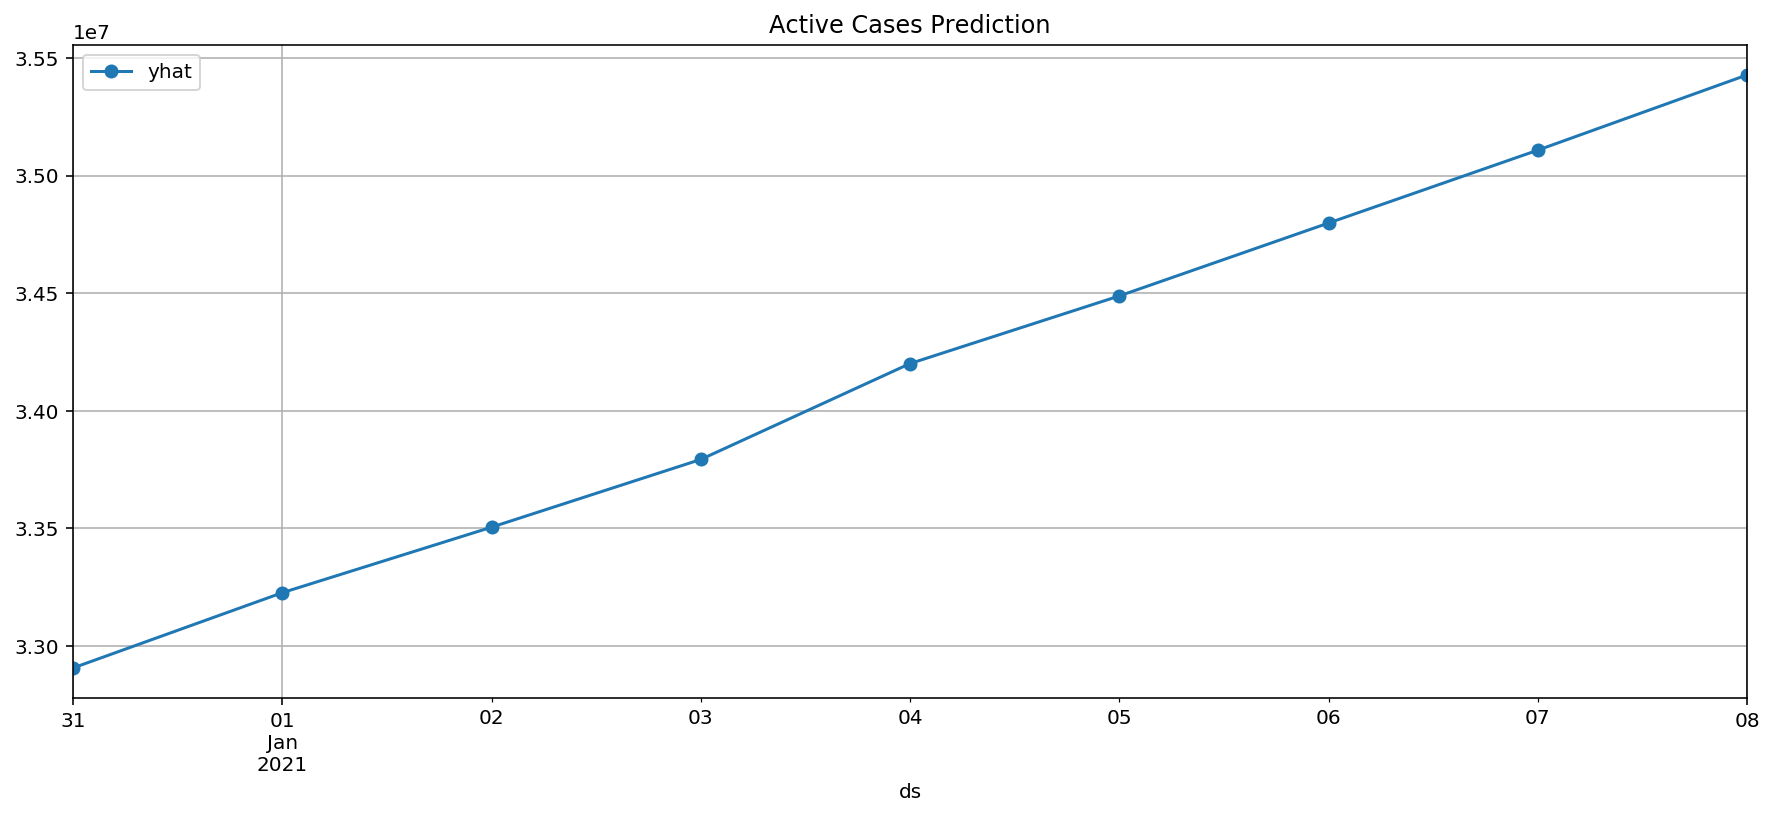

In [174]:
data_active_cases = forecast_active_cases[['ds','yhat']].iloc[-10:-1]
data_active_cases.set_index('ds', inplace=True, drop=True)

ax = data_active_cases.plot(grid=True, figsize=(15, 6), marker='o', title='Active Cases Prediction')
plt.show()

In [175]:
data_active_cases

,yhat
ds,
2020-12-31,32906436.198
2021-01-01,33226557.747
2021-01-02,33505255.696
2021-01-03,33793520.897
2021-01-04,34201463.055
2021-01-05,34489116.999
2021-01-06,34799293.328
2021-01-07,35109306.458
2021-01-08,35429428.008


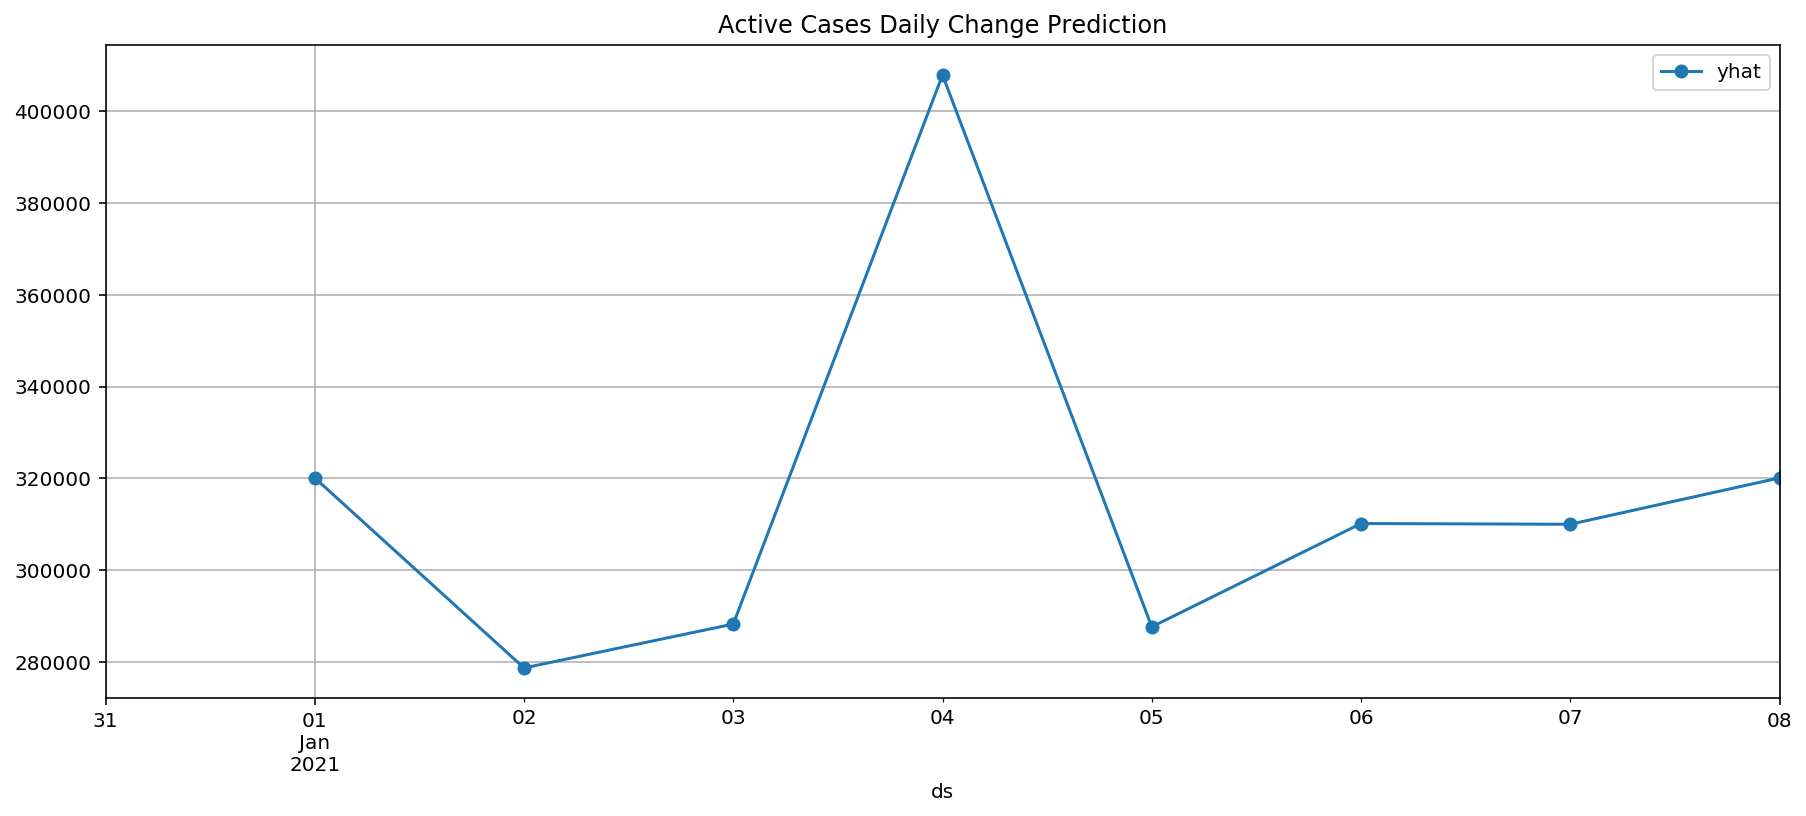

In [182]:
active_cases_change = data_active_cases.diff()

ax = active_cases_change.plot(grid=True, figsize=(15, 6), marker='o', title='Active Cases Daily Change Prediction')
plt.show()

In [183]:
active_cases_change

,yhat
ds,
2020-12-31,nan
2021-01-01,320121.550
2021-01-02,278697.949
2021-01-03,288265.201
2021-01-04,407942.158
2021-01-05,287653.944
2021-01-06,310176.330
2021-01-07,310013.129
2021-01-08,320121.550


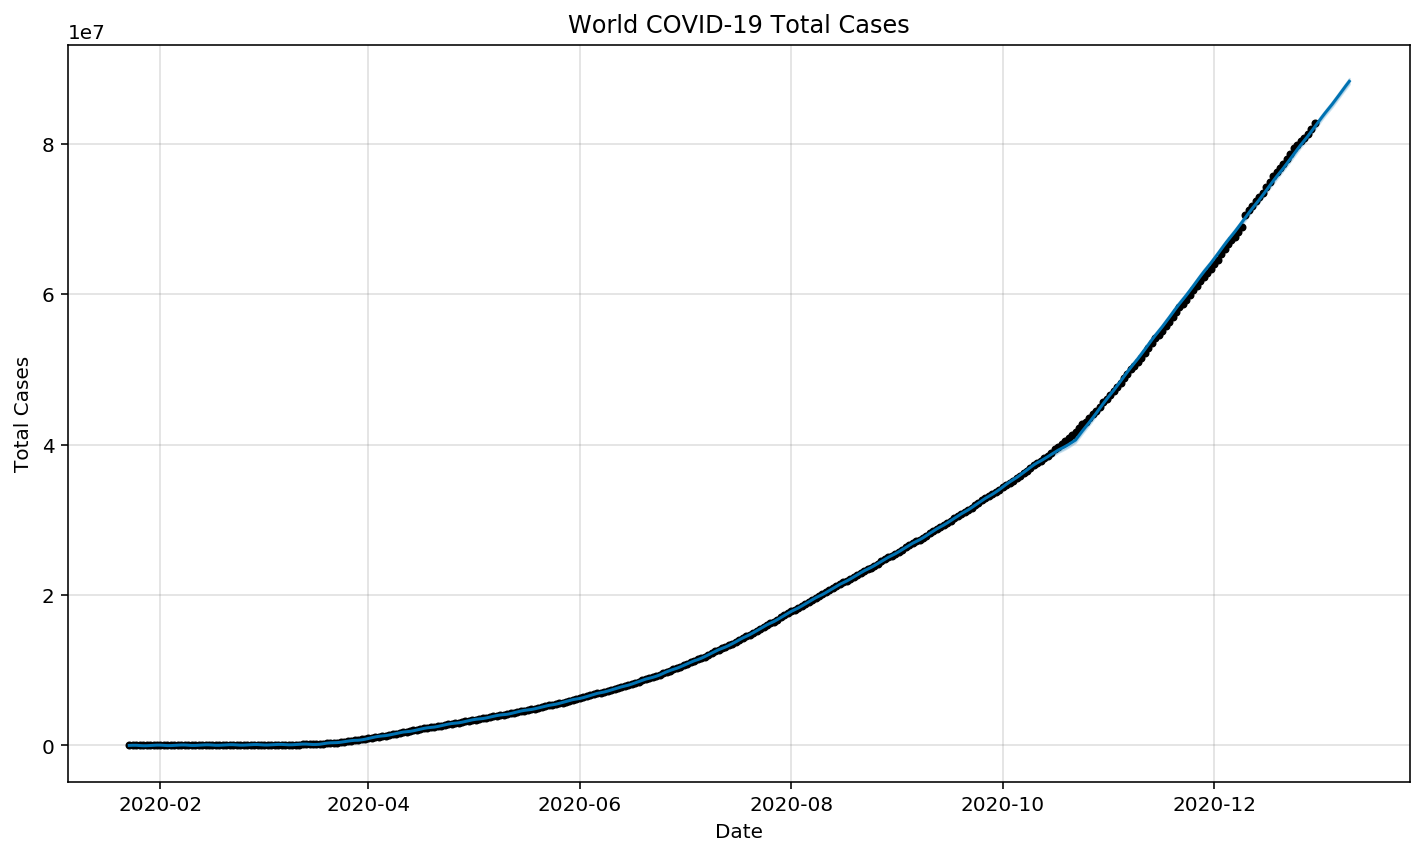

In [184]:
prophet_cases.plot(forecast_cases, xlabel='Date', ylabel='Total Cases')
plt.title('World COVID-19 Total Cases')
plt.show()

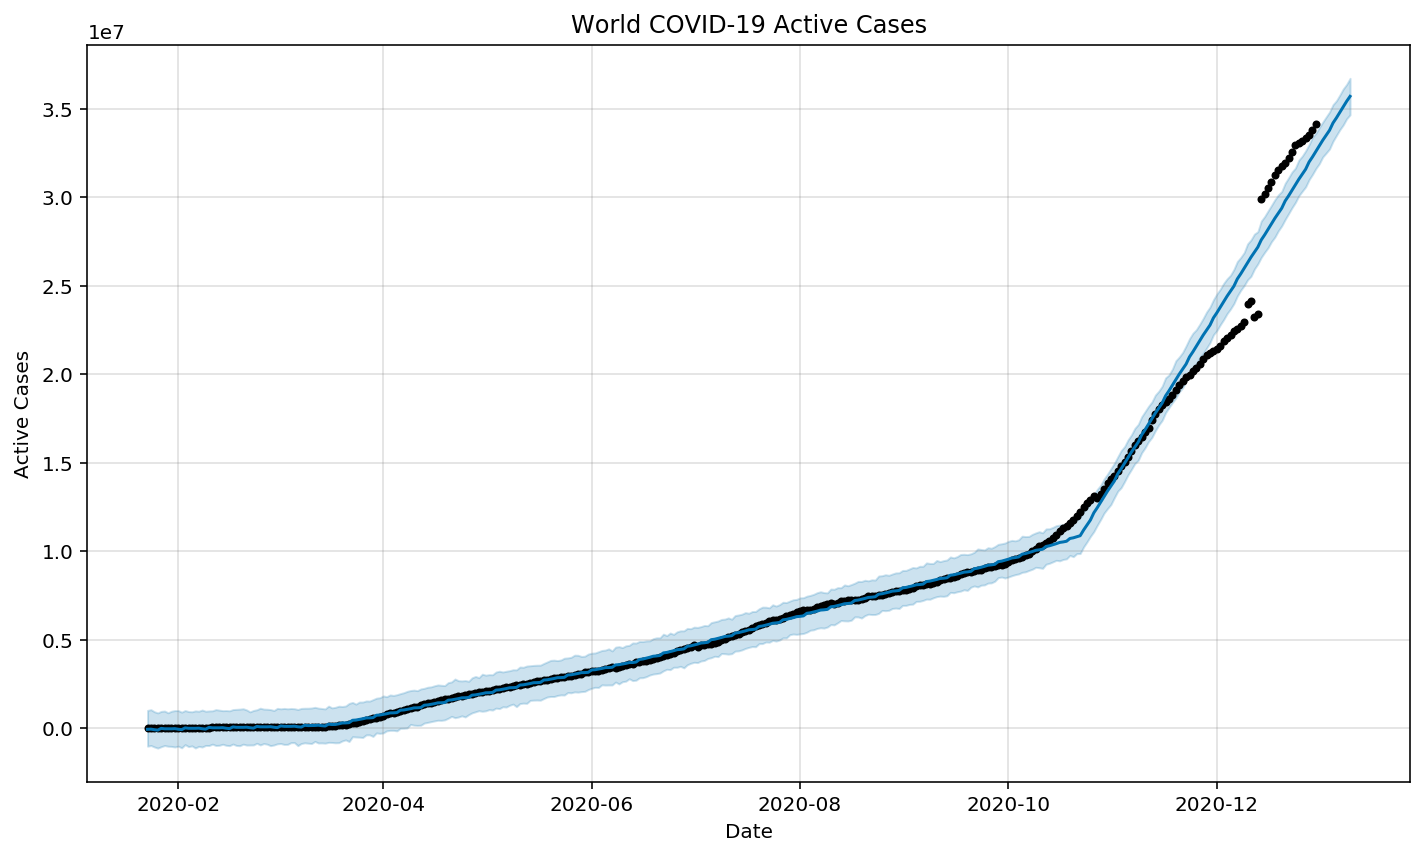

In [185]:
prophet_active_cases.plot(forecast_active_cases, xlabel='Date', ylabel='Active Cases')
plt.title('World COVID-19 Active Cases')
plt.show()

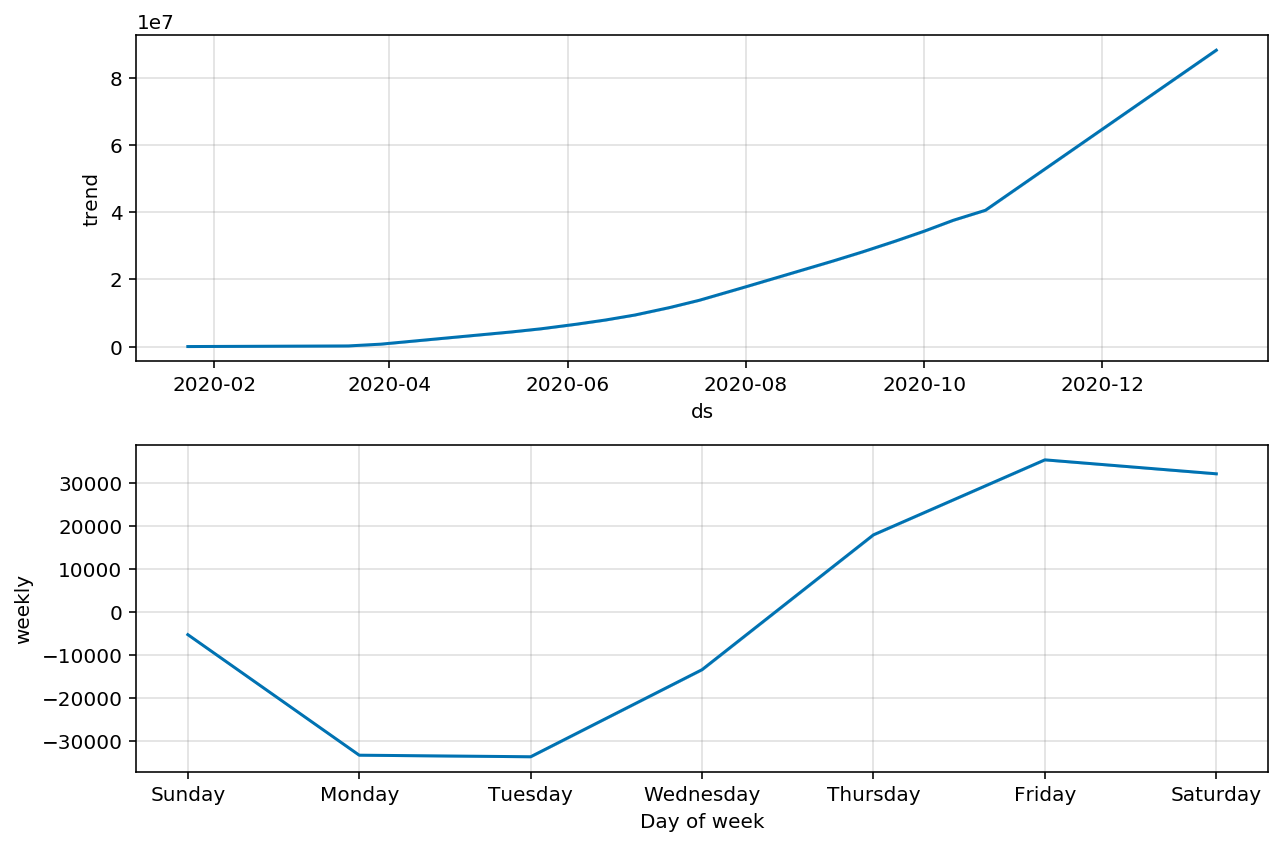

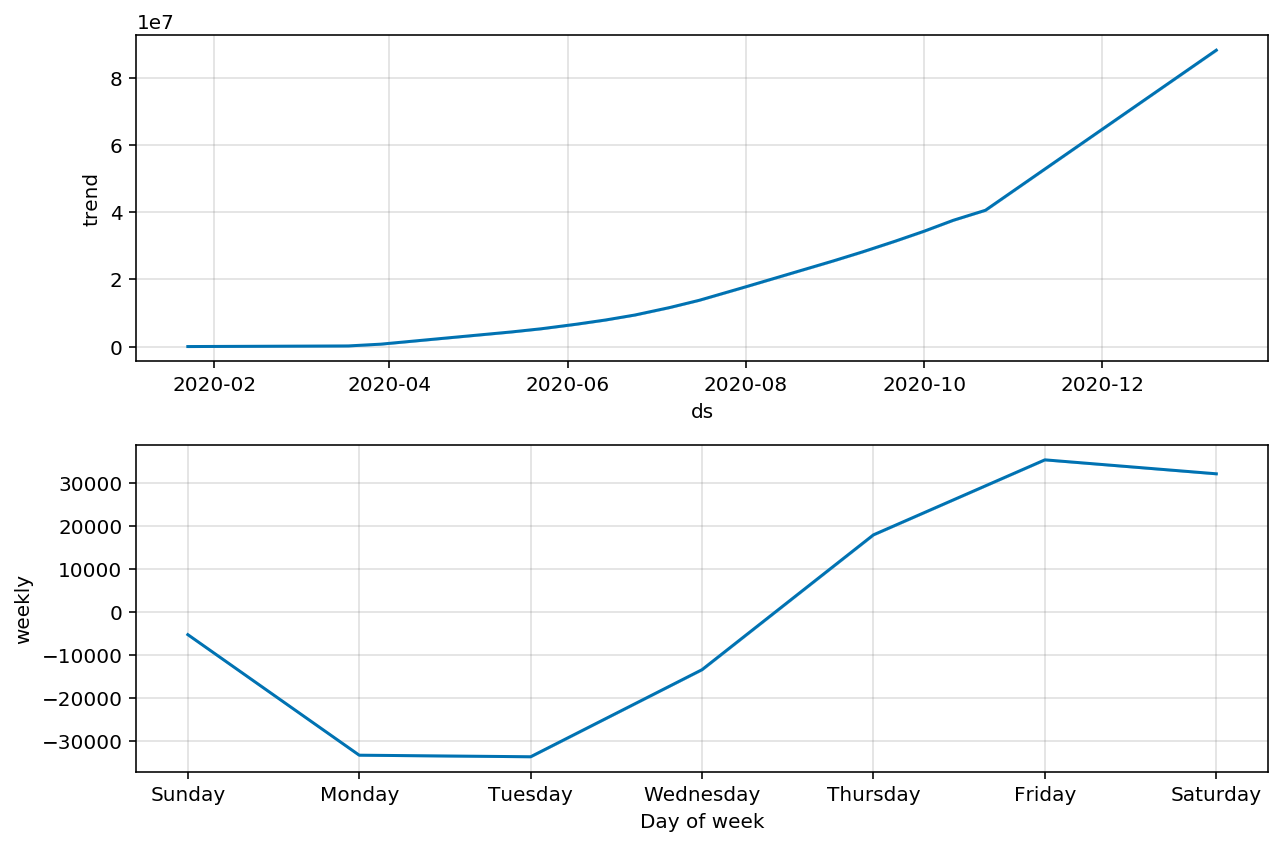

In [180]:
prophet_cases.plot_components(forecast_cases)

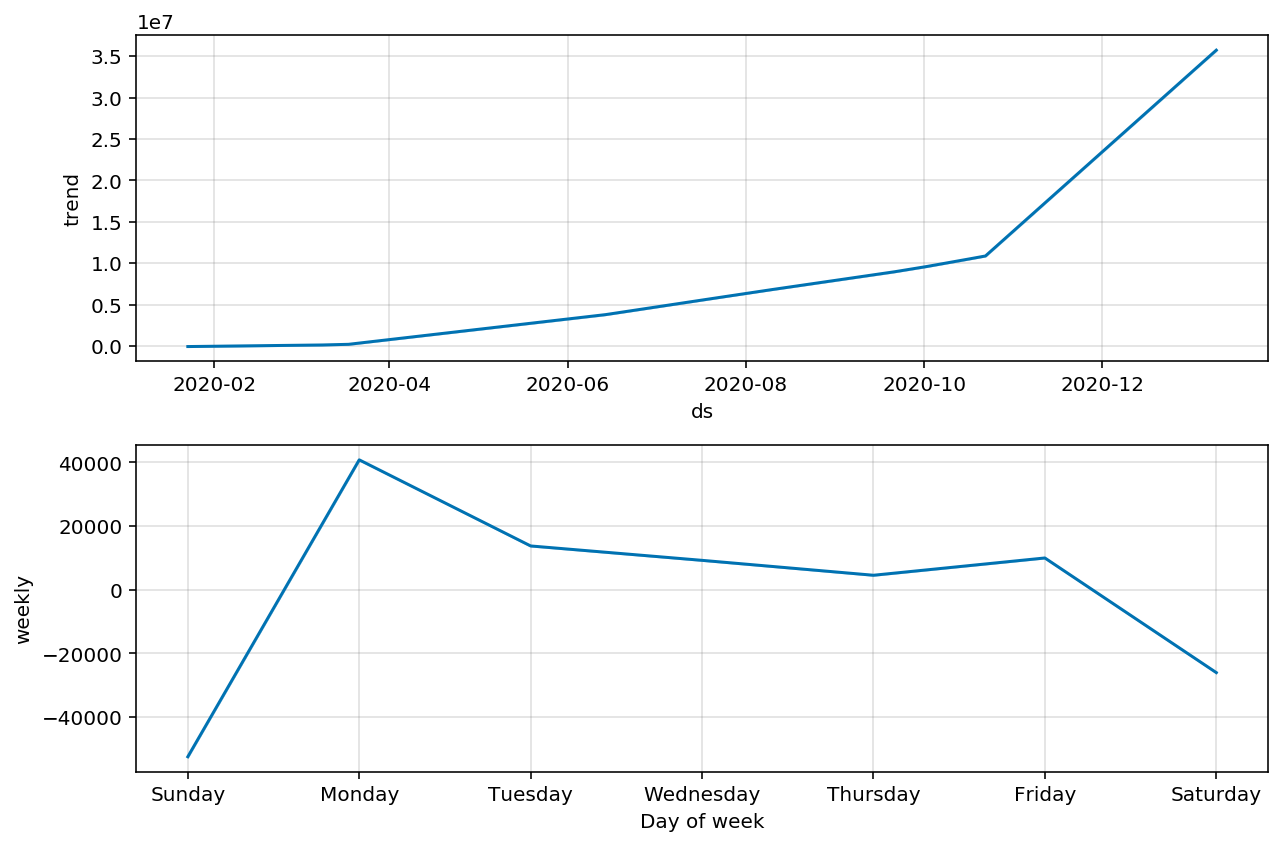

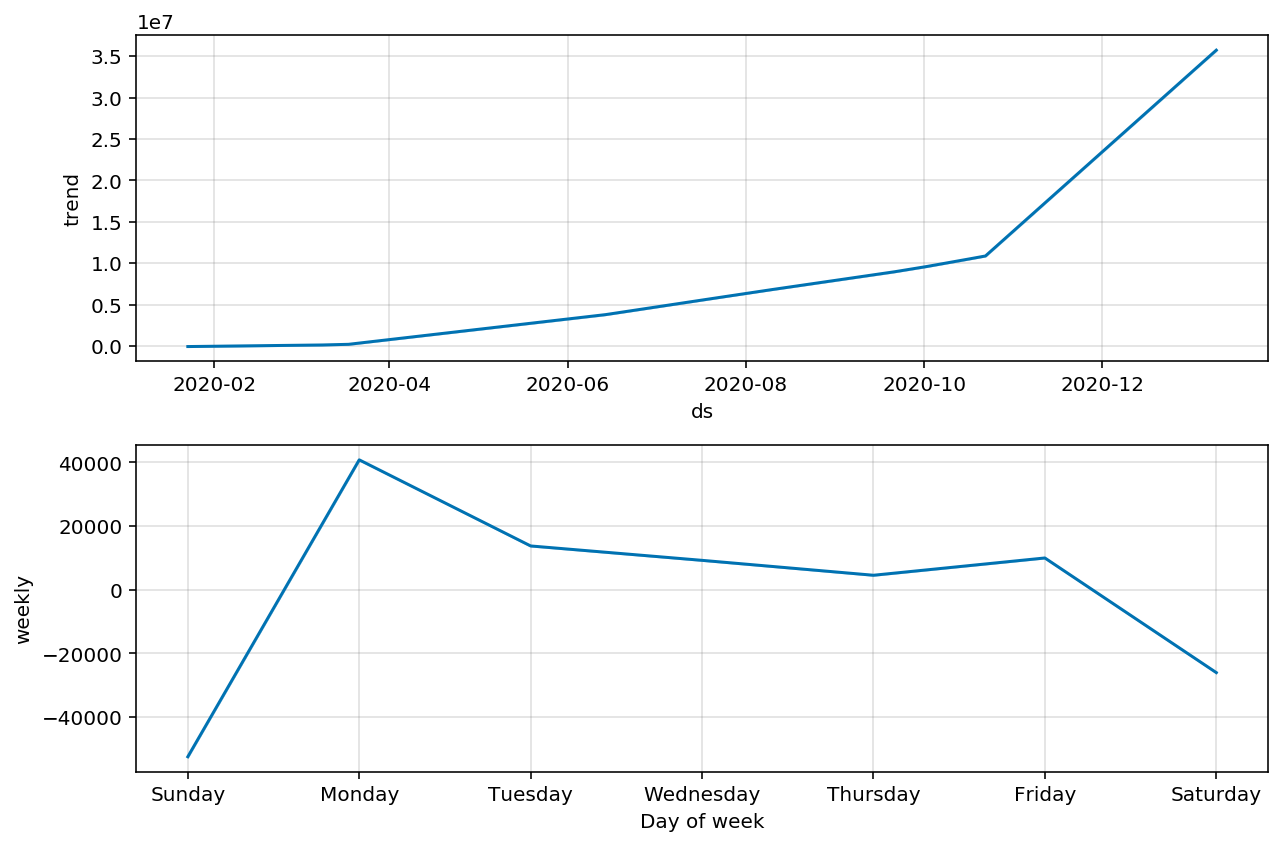

In [181]:
prophet_active_cases.plot_components(forecast_active_cases)